# Etapa 3: Modelagem Preditiva - Parte 1
## Modelos Baseline e Estatísticos

Neste notebook implementaremos:
- Modelos baseline (Naive, Média Móvel, Suavização Exponencial)
- Modelos estatísticos (ARIMA, SARIMA, Holt-Winters)

In [1]:
# Instalação de bibliotecas específicas para séries temporais
#!pip install statsmodels pmdarima --break-system-packages -q

In [2]:
# Importações
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

# Modelos estatísticos
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

# Métricas
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print("✓ Bibliotecas importadas com sucesso!")

✓ Bibliotecas importadas com sucesso!


In [3]:
# Carregar dados
train_data = pd.read_csv('train_data.csv', parse_dates=['Date'])
val_data = pd.read_csv('val_data.csv', parse_dates=['Date'])
test_data = pd.read_csv('test_data.csv', parse_dates=['Date'])

print(f"Train: {len(train_data)} registros")
print(f"Validation: {len(val_data)} registros")
print(f"Test: {len(test_data)} registros")

# Criar dicionário de resultados
results = {}

Train: 2979 registros
Validation: 990 registros
Test: 981 registros


## 1. Funções de Avaliação

In [4]:
def calculate_metrics(y_true, y_pred, model_name="Model"):
    """
    Calcula métricas de avaliação para previsões de séries temporais
    """
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    
    metrics = {
        'Model': model_name,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'R²': r2
    }
    
    return metrics

def plot_predictions(y_true, y_pred, dates, title, train_data=None):
    """
    Plota valores reais vs preditos
    """
    plt.figure(figsize=(15, 5))
    
    if train_data is not None:
        plt.plot(train_data['Date'], train_data['Views'], 
                label='Treino', alpha=0.5, linewidth=1)
    
    plt.plot(dates, y_true, label='Real', marker='o', linewidth=2)
    plt.plot(dates, y_pred, label='Predição', marker='s', linewidth=2, linestyle='--')
    
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Data', fontsize=12)
    plt.ylabel('Visualizações', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

print("✓ Funções de avaliação definidas")

✓ Funções de avaliação definidas


## 2. Modelos Baseline

### 2.1 Modelo Naive (Persistência)

MODELO NAIVE (BASELINE)

Processando: 2NE1_zh.wikipedia.org_all-access_spider...


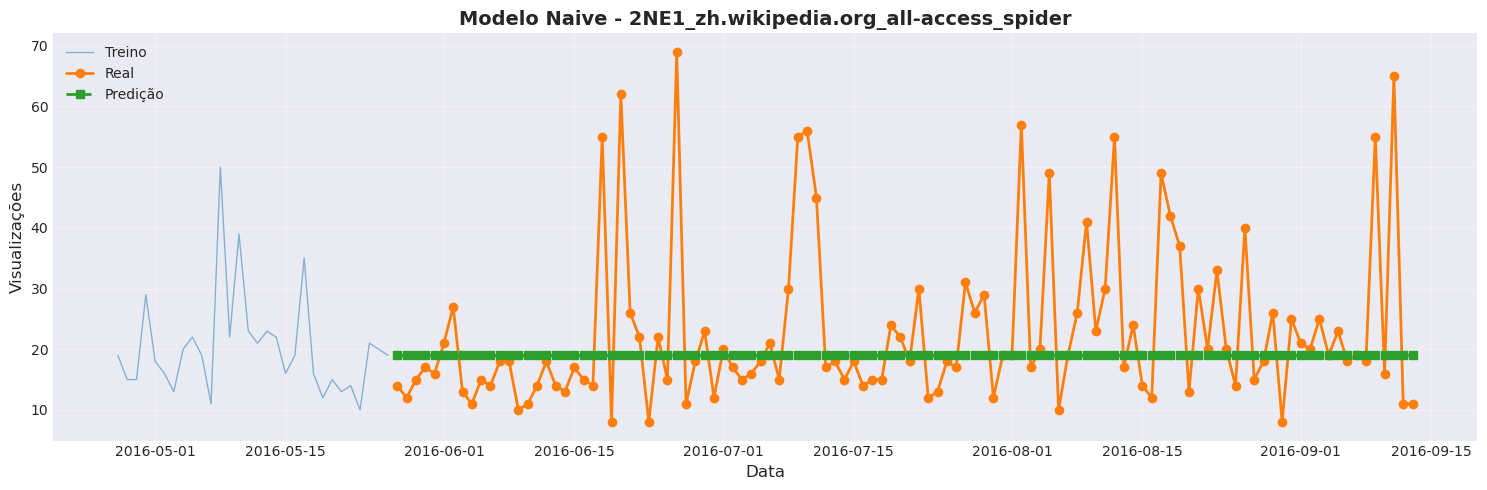


Processando: 2PM_zh.wikipedia.org_all-access_spider...

Processando: 3C_zh.wikipedia.org_all-access_spider...

Processando: 4minute_zh.wikipedia.org_all-access_spider...

Processando: 52_Hz_I_Love_You_zh.wikipedia.org_all-access_spide...

Processando: 5566_zh.wikipedia.org_all-access_spider...

Processando: 91Days_zh.wikipedia.org_all-access_spider...

Processando: A'N'D_zh.wikipedia.org_all-access_spider...

Processando: AKB48_zh.wikipedia.org_all-access_spider...

RESULTADOS MÉDIOS - NAIVE
MAE     13.987273
RMSE    19.039505
MAPE          inf
R²      -0.491287
dtype: float64


In [5]:
print("="*60)
print("MODELO NAIVE (BASELINE)")
print("="*60)

# Implementar para cada página
naive_results = []

for page in train_data['Page'].unique():
    print(f"\nProcessando: {page[:50]}...")
    
    # Dados de treino e validação da página
    page_train = train_data[train_data['Page'] == page].sort_values('Date')
    page_val = val_data[val_data['Page'] == page].sort_values('Date')
    
    if len(page_val) > 0:
        # Previsão Naive: último valor observado
        last_value = page_train['Views'].iloc[-1]
        naive_pred = np.full(len(page_val), last_value)
        
        # Calcular métricas
        metrics = calculate_metrics(page_val['Views'].values, naive_pred, "Naive")
        metrics['Page'] = page
        naive_results.append(metrics)
        
        # Visualizar primeira página
        if page == train_data['Page'].unique()[0]:
            plot_predictions(page_val['Views'].values, naive_pred, 
                           page_val['Date'].values, 
                           f'Modelo Naive - {page[:40]}',
                           page_train[-30:])

# Consolidar resultados
naive_df = pd.DataFrame(naive_results)
print("\n" + "="*60)
print("RESULTADOS MÉDIOS - NAIVE")
print("="*60)
print(naive_df[['MAE', 'RMSE', 'MAPE', 'R²']].mean())

results['Naive'] = naive_df

### 2.2 Média Móvel Simples

MÉDIA MÓVEL SIMPLES

Testando janela de 7 dias...


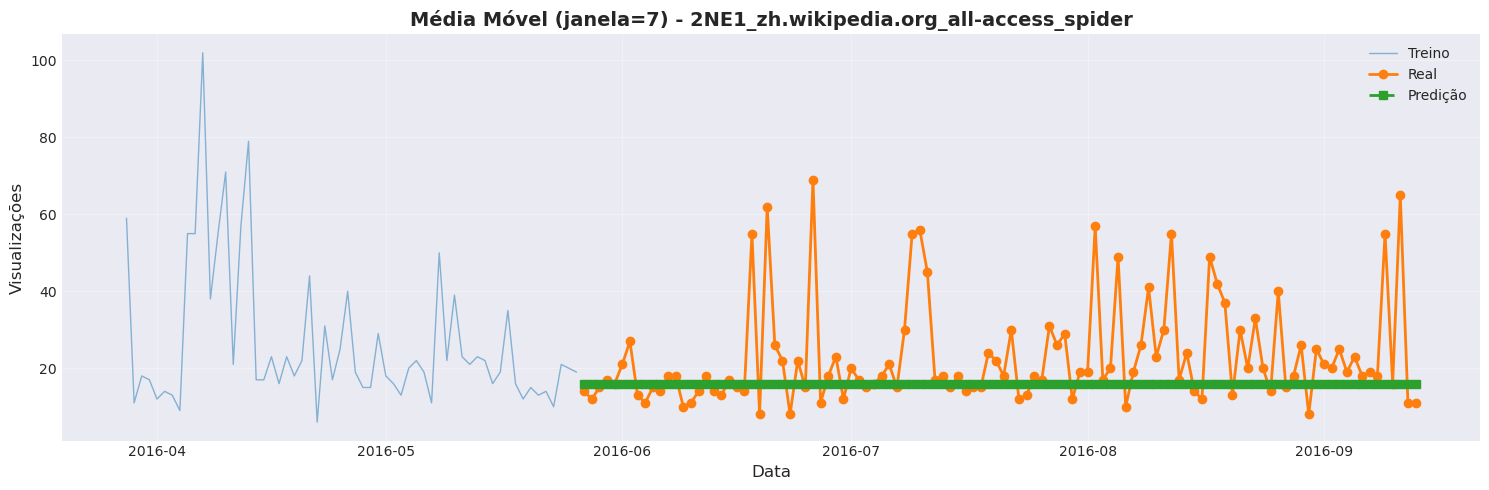

  Média MAE: 11.53
  Média RMSE: 16.99

Testando janela de 14 dias...
  Média MAE: 11.38
  Média RMSE: 16.86

Testando janela de 30 dias...
  Média MAE: 11.09
  Média RMSE: 16.01

✓ Melhor janela: 30 dias


In [6]:
print("="*60)
print("MÉDIA MÓVEL SIMPLES")
print("="*60)

window_sizes = [7, 14, 30]  # Testar diferentes janelas
ma_results = {}

for window in window_sizes:
    print(f"\nTestando janela de {window} dias...")
    window_results = []
    
    for page in train_data['Page'].unique():
        page_train = train_data[train_data['Page'] == page].sort_values('Date')
        page_val = val_data[val_data['Page'] == page].sort_values('Date')
        
        if len(page_val) > 0 and len(page_train) >= window:
            # Previsão: média dos últimos N valores
            ma_value = page_train['Views'].iloc[-window:].mean()
            ma_pred = np.full(len(page_val), ma_value)
            
            # Métricas
            metrics = calculate_metrics(page_val['Views'].values, ma_pred, 
                                       f"MA_{window}")
            metrics['Page'] = page
            metrics['Window'] = window
            window_results.append(metrics)
            
            # Visualizar primeira página com melhor janela
            if page == train_data['Page'].unique()[0] and window == 7:
                plot_predictions(page_val['Views'].values, ma_pred, 
                               page_val['Date'].values, 
                               f'Média Móvel (janela={window}) - {page[:40]}',
                               page_train[-60:])
    
    ma_results[window] = pd.DataFrame(window_results)
    print(f"  Média MAE: {ma_results[window]['MAE'].mean():.2f}")
    print(f"  Média RMSE: {ma_results[window]['RMSE'].mean():.2f}")

# Selecionar melhor janela
best_window = min(ma_results.keys(), 
                  key=lambda w: ma_results[w]['MAE'].mean())
print(f"\n✓ Melhor janela: {best_window} dias")

results['Moving_Average'] = ma_results[best_window]

### 2.3 Suavização Exponencial Simples

SUAVIZAÇÃO EXPONENCIAL SIMPLES

Processando: 2NE1_zh.wikipedia.org_all-access_spider...


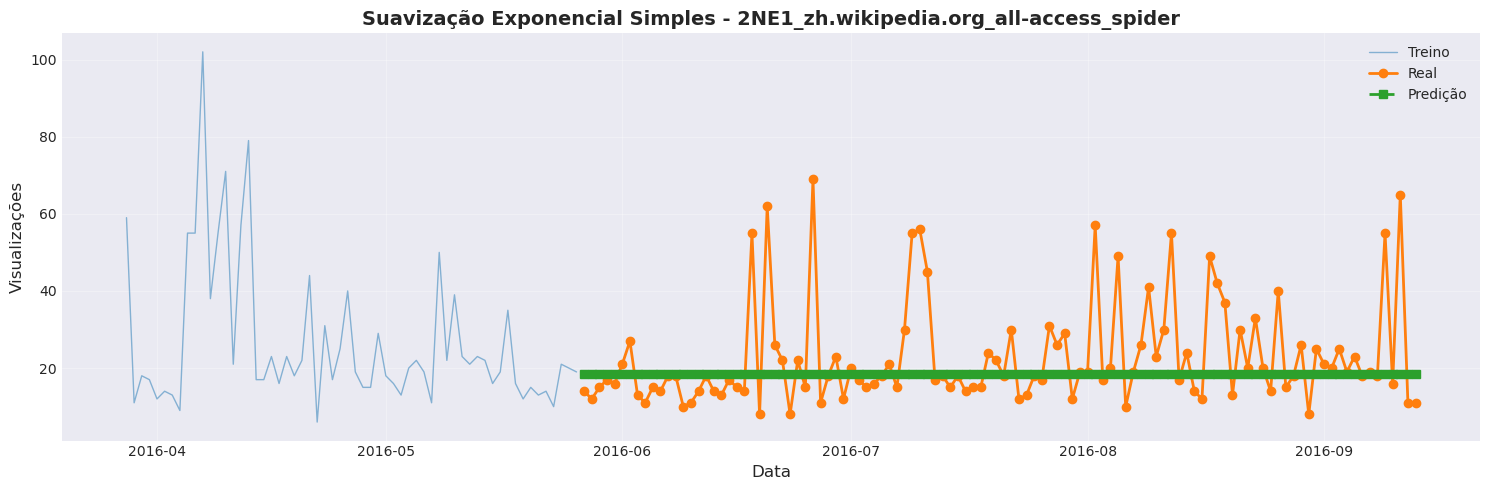

  Alpha otimizado: 0.1350

Processando: 2PM_zh.wikipedia.org_all-access_spider...

Processando: 3C_zh.wikipedia.org_all-access_spider...

Processando: 4minute_zh.wikipedia.org_all-access_spider...

Processando: 52_Hz_I_Love_You_zh.wikipedia.org_all-access_spide...

Processando: 5566_zh.wikipedia.org_all-access_spider...

Processando: 91Days_zh.wikipedia.org_all-access_spider...

Processando: A'N'D_zh.wikipedia.org_all-access_spider...

Processando: AKB48_zh.wikipedia.org_all-access_spider...

RESULTADOS MÉDIOS - SES
MAE     11.471647
RMSE    16.779681
MAPE          inf
R²      -0.238649
dtype: float64


In [7]:
print("="*60)
print("SUAVIZAÇÃO EXPONENCIAL SIMPLES")
print("="*60)

ses_results = []

for page in train_data['Page'].unique():
    print(f"\nProcessando: {page[:50]}...")
    
    page_train = train_data[train_data['Page'] == page].sort_values('Date')
    page_val = val_data[val_data['Page'] == page].sort_values('Date')
    
    if len(page_val) > 0 and len(page_train) > 10:
        try:
            # Ajustar modelo SES
            model = ExponentialSmoothing(page_train['Views'].values, 
                                        trend=None, seasonal=None)
            fitted_model = model.fit()
            
            # Fazer previsões
            ses_pred = fitted_model.forecast(steps=len(page_val))
            
            # Métricas
            metrics = calculate_metrics(page_val['Views'].values, ses_pred, "SES")
            metrics['Page'] = page
            metrics['Alpha'] = fitted_model.params['smoothing_level']
            ses_results.append(metrics)
            
            # Visualizar primeira página
            if page == train_data['Page'].unique()[0]:
                plot_predictions(page_val['Views'].values, ses_pred, 
                               page_val['Date'].values, 
                               f'Suavização Exponencial Simples - {page[:40]}',
                               page_train[-60:])
                print(f"  Alpha otimizado: {fitted_model.params['smoothing_level']:.4f}")
        
        except Exception as e:
            print(f"  Erro ao ajustar SES: {e}")

# Consolidar resultados
ses_df = pd.DataFrame(ses_results)
print("\n" + "="*60)
print("RESULTADOS MÉDIOS - SES")
print("="*60)
print(ses_df[['MAE', 'RMSE', 'MAPE', 'R²']].mean())

results['SES'] = ses_df

## 3. Modelos Estatísticos Avançados

### 3.1 ARIMA

MODELO ARIMA
Usando auto_arima para encontrar parâmetros ótimos...

Processando: 2NE1_zh.wikipedia.org_all-access_spider...
  Ordem otimizada: (0, 1, 1)
  AIC: 2670.71


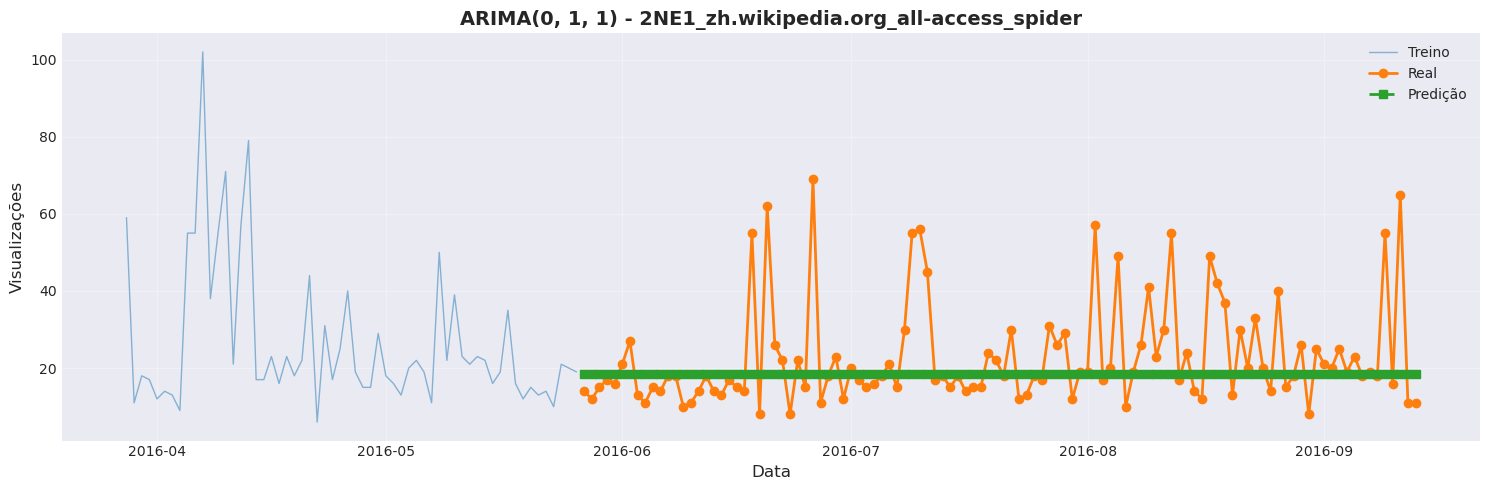

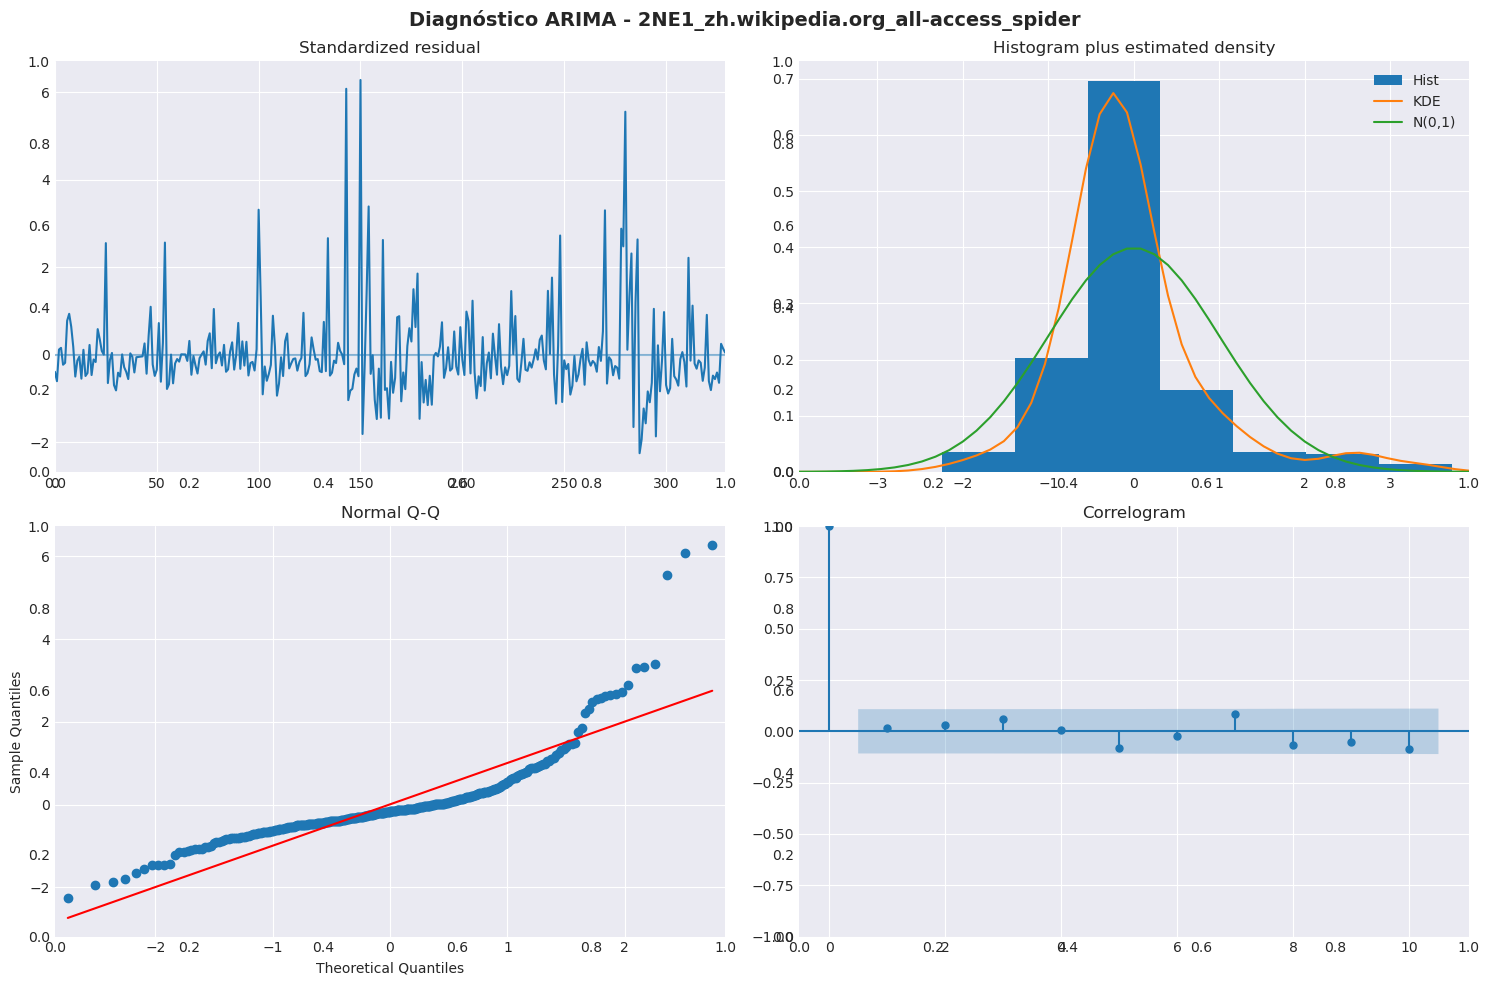

Processando: 2PM_zh.wikipedia.org_all-access_spider...
  Ordem otimizada: (3, 0, 1)
  AIC: 2736.29
Processando: 3C_zh.wikipedia.org_all-access_spider...
  Ordem otimizada: (0, 1, 2)
  AIC: 1618.24
Processando: 4minute_zh.wikipedia.org_all-access_spider...
  Ordem otimizada: (1, 0, 1)
  AIC: 2474.19
Processando: 52_Hz_I_Love_You_zh.wikipedia.org_all-access_spide...
  Ordem otimizada: (5, 1, 3)
  AIC: 1852.94
Processando: 5566_zh.wikipedia.org_all-access_spider...
  Ordem otimizada: (1, 1, 1)
  AIC: 2213.93
Processando: 91Days_zh.wikipedia.org_all-access_spider...
  Ordem otimizada: (0, 0, 0)
  AIC: 2586.35
Processando: A'N'D_zh.wikipedia.org_all-access_spider...
  Ordem otimizada: (4, 0, 0)
  AIC: 3261.80
Processando: AKB48_zh.wikipedia.org_all-access_spider...
  Ordem otimizada: (1, 1, 1)
  AIC: 2727.17

RESULTADOS MÉDIOS - ARIMA
MAE     12.110520
RMSE    16.866963
MAPE          inf
R²      -0.443092
dtype: float64


In [8]:
print("="*60)
print("MODELO ARIMA")
print("="*60)
print("Usando auto_arima para encontrar parâmetros ótimos...\n")

arima_results = []

for page in train_data['Page'].unique():
    print(f"Processando: {page[:50]}...")
    
    page_train = train_data[train_data['Page'] == page].sort_values('Date')
    page_val = val_data[val_data['Page'] == page].sort_values('Date')
    
    if len(page_val) > 0 and len(page_train) > 20:
        try:
            # Auto ARIMA para encontrar melhores parâmetros
            auto_model = auto_arima(page_train['Views'].values,
                                   start_p=0, start_q=0,
                                   max_p=5, max_q=5,
                                   seasonal=False,
                                   stepwise=True,
                                   suppress_warnings=True,
                                   error_action='ignore',
                                   trace=False)
            
            # Fazer previsões
            arima_pred = auto_model.predict(n_periods=len(page_val))
            
            # Métricas
            metrics = calculate_metrics(page_val['Views'].values, arima_pred, "ARIMA")
            metrics['Page'] = page
            metrics['Order'] = str(auto_model.order)
            metrics['AIC'] = auto_model.aic()
            arima_results.append(metrics)
            
            print(f"  Ordem otimizada: {auto_model.order}")
            print(f"  AIC: {auto_model.aic():.2f}")
            
            # Visualizar primeira página
            if page == train_data['Page'].unique()[0]:
                plot_predictions(page_val['Views'].values, arima_pred, 
                               page_val['Date'].values, 
                               f'ARIMA{auto_model.order} - {page[:40]}',
                               page_train[-60:])
                
                # Diagnóstico do modelo
                fig, axes = plt.subplots(2, 2, figsize=(15, 10))
                auto_model.plot_diagnostics(fig=fig)
                plt.suptitle(f'Diagnóstico ARIMA - {page[:40]}', fontsize=14, fontweight='bold')
                plt.tight_layout()
                plt.show()
        
        except Exception as e:
            print(f"  Erro ao ajustar ARIMA: {e}")

# Consolidar resultados
arima_df = pd.DataFrame(arima_results)
print("\n" + "="*60)
print("RESULTADOS MÉDIOS - ARIMA")
print("="*60)
print(arima_df[['MAE', 'RMSE', 'MAPE', 'R²']].mean())

results['ARIMA'] = arima_df

### 3.2 SARIMA (Seasonal ARIMA)

MODELO SARIMA
Usando auto_arima com sazonalidade semanal (period=7)...

Processando: 2NE1_zh.wikipedia.org_all-access_spider...
  Ordem: (3, 0, 0)
  Ordem Sazonal: (2, 1, 1, 7)
  AIC: 2639.76


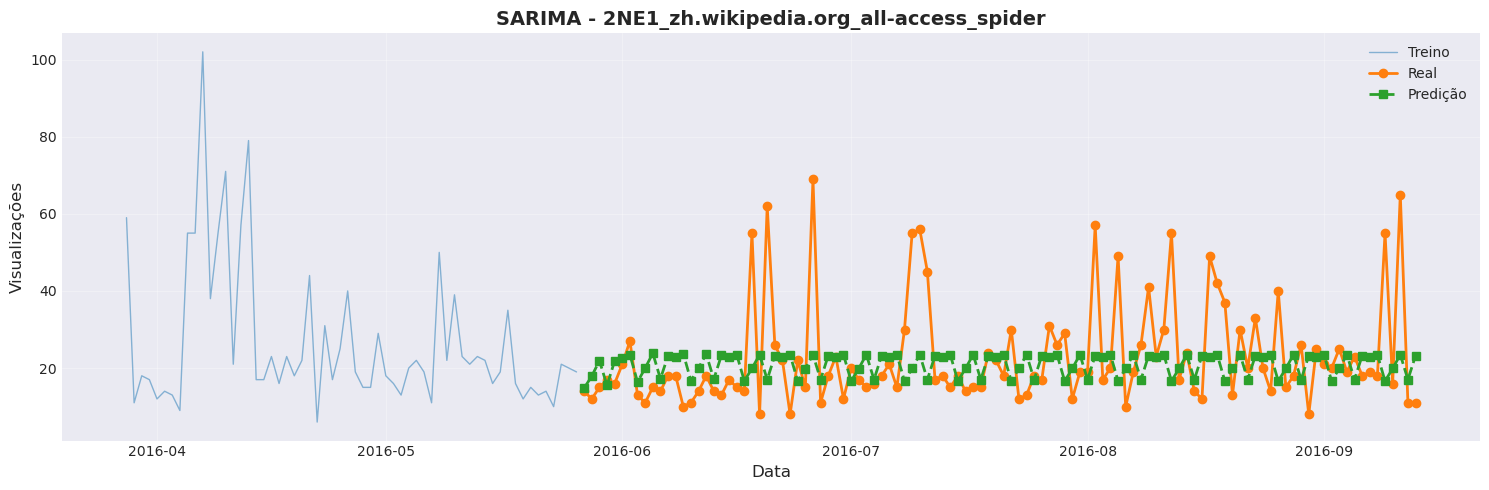

Processando: 2PM_zh.wikipedia.org_all-access_spider...
  Ordem: (2, 0, 0)
  Ordem Sazonal: (0, 1, 1, 7)
  AIC: 2711.41
Processando: 3C_zh.wikipedia.org_all-access_spider...
  Ordem: (1, 0, 1)
  Ordem Sazonal: (2, 1, 0, 7)
  AIC: 1665.17
Processando: 4minute_zh.wikipedia.org_all-access_spider...
  Ordem: (0, 0, 0)
  Ordem Sazonal: (2, 1, 0, 7)
  AIC: 2528.80
Processando: 52_Hz_I_Love_You_zh.wikipedia.org_all-access_spide...
  Ordem: (3, 0, 1)
  Ordem Sazonal: (1, 1, 2, 7)
  AIC: 1899.73
Processando: 5566_zh.wikipedia.org_all-access_spider...
  Ordem: (1, 0, 1)
  Ordem Sazonal: (0, 1, 1, 7)
  AIC: 2198.11
Processando: 91Days_zh.wikipedia.org_all-access_spider...
  Ordem: (0, 0, 0)
  Ordem Sazonal: (0, 0, 0, 0)
  AIC: 2586.35
Processando: A'N'D_zh.wikipedia.org_all-access_spider...
  Ordem: (2, 0, 0)
  Ordem Sazonal: (2, 1, 0, 7)
  AIC: 3296.10
Processando: AKB48_zh.wikipedia.org_all-access_spider...
  Ordem: (1, 0, 1)
  Ordem Sazonal: (0, 1, 1, 7)
  AIC: 2713.75

RESULTADOS MÉDIOS - SARI

In [9]:
print("="*60)
print("MODELO SARIMA")
print("="*60)
print("Usando auto_arima com sazonalidade semanal (period=7)...\n")

sarima_results = []

for page in train_data['Page'].unique():
    print(f"Processando: {page[:50]}...")
    
    page_train = train_data[train_data['Page'] == page].sort_values('Date')
    page_val = val_data[val_data['Page'] == page].sort_values('Date')
    
    if len(page_val) > 0 and len(page_train) > 30:
        try:
            # Auto ARIMA com sazonalidade
            auto_model = auto_arima(page_train['Views'].values,
                                   start_p=0, start_q=0,
                                   max_p=3, max_q=3,
                                   seasonal=True, m=7,
                                   start_P=0, start_Q=0,
                                   max_P=2, max_Q=2,
                                   D=1,
                                   stepwise=True,
                                   suppress_warnings=True,
                                   error_action='ignore',
                                   trace=False)
            
            # Fazer previsões
            sarima_pred = auto_model.predict(n_periods=len(page_val))
            
            # Métricas
            metrics = calculate_metrics(page_val['Views'].values, sarima_pred, "SARIMA")
            metrics['Page'] = page
            metrics['Order'] = str(auto_model.order)
            metrics['Seasonal_Order'] = str(auto_model.seasonal_order)
            metrics['AIC'] = auto_model.aic()
            sarima_results.append(metrics)
            
            print(f"  Ordem: {auto_model.order}")
            print(f"  Ordem Sazonal: {auto_model.seasonal_order}")
            print(f"  AIC: {auto_model.aic():.2f}")
            
            # Visualizar primeira página
            if page == train_data['Page'].unique()[0]:
                plot_predictions(page_val['Views'].values, sarima_pred, 
                               page_val['Date'].values, 
                               f'SARIMA - {page[:40]}',
                               page_train[-60:])
        
        except Exception as e:
            print(f"  Erro ao ajustar SARIMA: {e}")

# Consolidar resultados
sarima_df = pd.DataFrame(sarima_results)
print("\n" + "="*60)
print("RESULTADOS MÉDIOS - SARIMA")
print("="*60)
print(sarima_df[['MAE', 'RMSE', 'MAPE', 'R²']].mean())

results['SARIMA'] = sarima_df

### 3.3 Holt-Winters (Triple Exponential Smoothing)

HOLT-WINTERS (TRIPLE EXPONENTIAL SMOOTHING)

Processando: 2NE1_zh.wikipedia.org_all-access_spider...


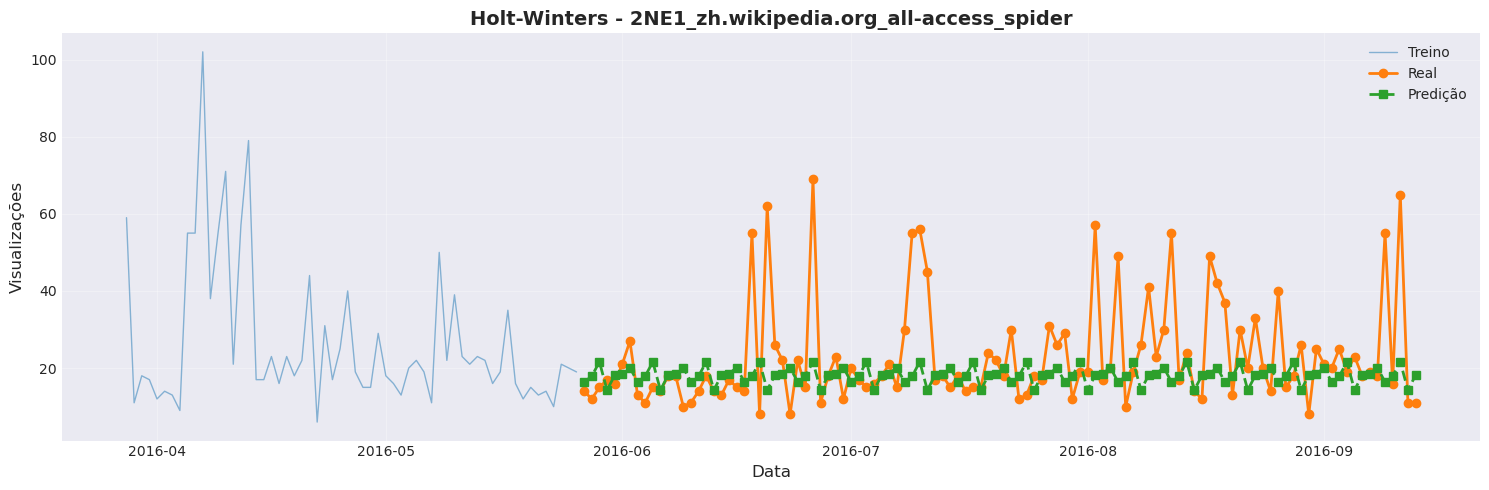

  Parâmetros otimizados:
    Alpha (level): 0.1428
    Beta (trend): 0.0000
    Gamma (seasonal): 0.0000

Processando: 2PM_zh.wikipedia.org_all-access_spider...

Processando: 3C_zh.wikipedia.org_all-access_spider...

Processando: 4minute_zh.wikipedia.org_all-access_spider...

Processando: 52_Hz_I_Love_You_zh.wikipedia.org_all-access_spide...

Processando: 5566_zh.wikipedia.org_all-access_spider...

Processando: 91Days_zh.wikipedia.org_all-access_spider...

Processando: A'N'D_zh.wikipedia.org_all-access_spider...

Processando: AKB48_zh.wikipedia.org_all-access_spider...

RESULTADOS MÉDIOS - HOLT-WINTERS
MAE     11.636059
RMSE    16.738424
MAPE          inf
R²      -0.249301
dtype: float64


In [10]:
print("="*60)
print("HOLT-WINTERS (TRIPLE EXPONENTIAL SMOOTHING)")
print("="*60)

hw_results = []

for page in train_data['Page'].unique():
    print(f"\nProcessando: {page[:50]}...")
    
    page_train = train_data[train_data['Page'] == page].sort_values('Date')
    page_val = val_data[val_data['Page'] == page].sort_values('Date')
    
    if len(page_val) > 0 and len(page_train) > 14:
        try:
            # Ajustar modelo Holt-Winters
            model = ExponentialSmoothing(
                page_train['Views'].values,
                seasonal_periods=7,
                trend='add',
                seasonal='add',
                damped_trend=True
            )
            fitted_model = model.fit()
            
            # Fazer previsões
            hw_pred = fitted_model.forecast(steps=len(page_val))
            
            # Métricas
            metrics = calculate_metrics(page_val['Views'].values, hw_pred, "Holt-Winters")
            metrics['Page'] = page
            metrics['Alpha'] = fitted_model.params['smoothing_level']
            metrics['Beta'] = fitted_model.params['smoothing_trend']
            metrics['Gamma'] = fitted_model.params['smoothing_seasonal']
            hw_results.append(metrics)
            
            # Visualizar primeira página
            if page == train_data['Page'].unique()[0]:
                plot_predictions(page_val['Views'].values, hw_pred, 
                               page_val['Date'].values, 
                               f'Holt-Winters - {page[:40]}',
                               page_train[-60:])
                
                print(f"  Parâmetros otimizados:")
                print(f"    Alpha (level): {fitted_model.params['smoothing_level']:.4f}")
                print(f"    Beta (trend): {fitted_model.params['smoothing_trend']:.4f}")
                print(f"    Gamma (seasonal): {fitted_model.params['smoothing_seasonal']:.4f}")
        
        except Exception as e:
            print(f"  Erro ao ajustar Holt-Winters: {e}")

# Consolidar resultados
hw_df = pd.DataFrame(hw_results)
print("\n" + "="*60)
print("RESULTADOS MÉDIOS - HOLT-WINTERS")
print("="*60)
print(hw_df[['MAE', 'RMSE', 'MAPE', 'R²']].mean())

results['Holt_Winters'] = hw_df

## 4. Comparação de Modelos Baseline e Estatísticos

COMPARAÇÃO DE TODOS OS MODELOS

Métricas médias por modelo:
        Modelo       MAE      RMSE  MAPE        R²
Moving_Average 11.090323 16.005009   inf -0.220899
           SES 11.471647 16.779681   inf -0.238649
  Holt_Winters 11.636059 16.738424   inf -0.249301
         ARIMA 12.110520 16.866963   inf -0.443092
        SARIMA 13.012264 17.674725   inf -0.606043
         Naive 13.987273 19.039505   inf -0.491287


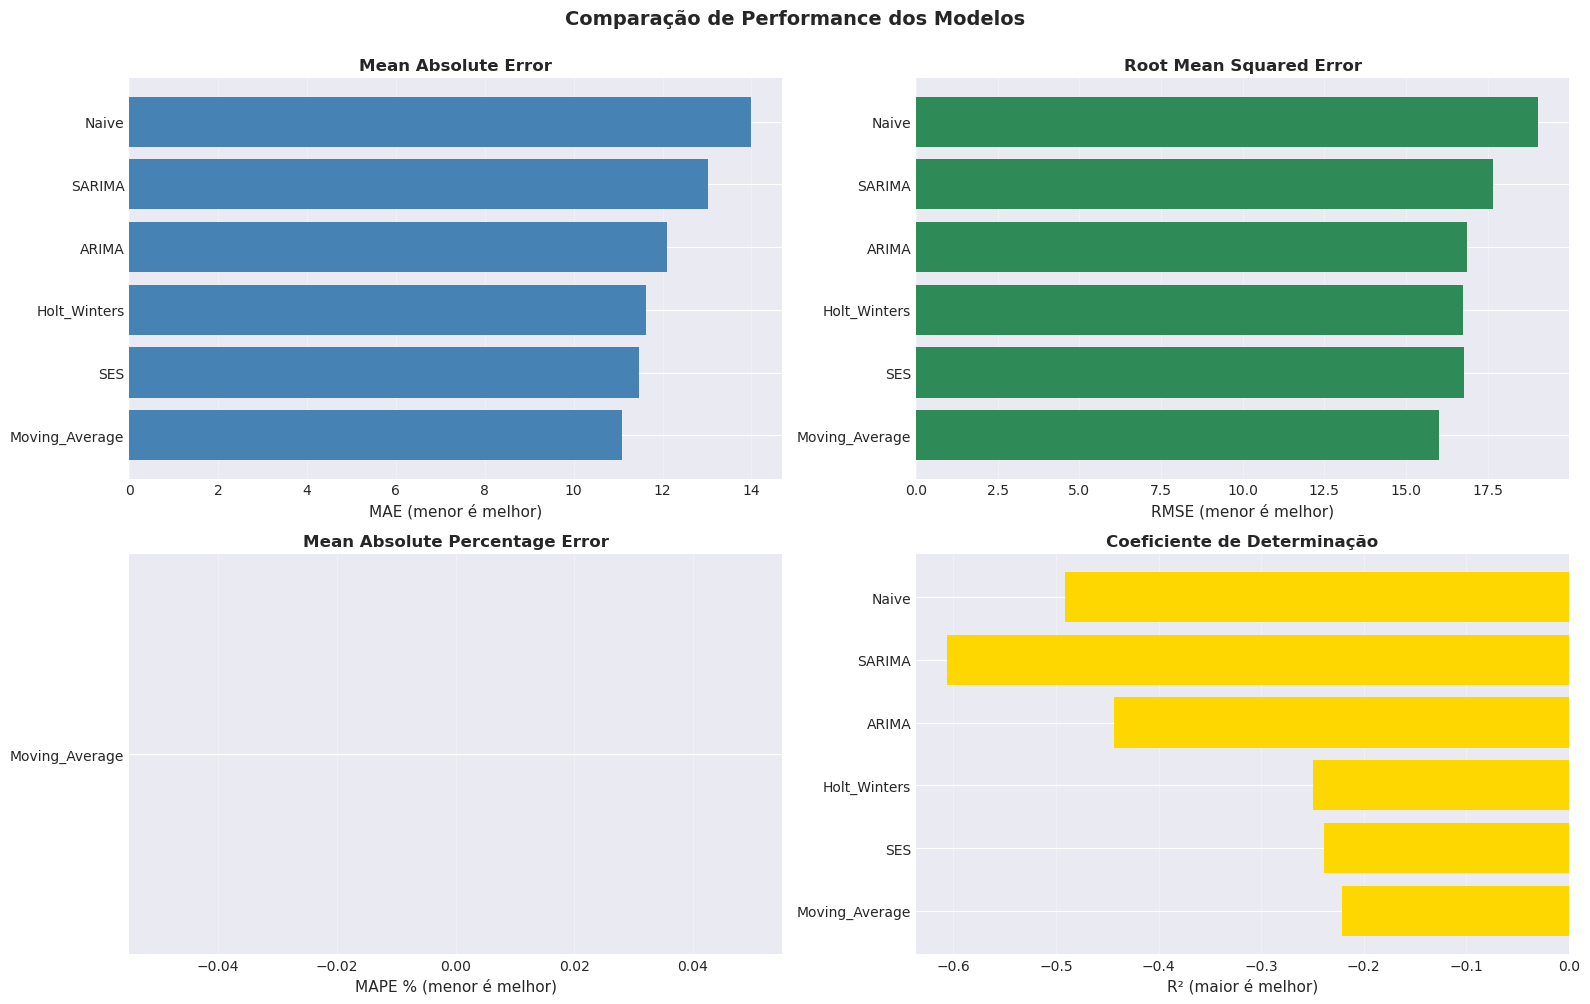


✓ MELHOR MODELO (Baseline/Estatístico): Moving_Average


In [11]:
print("="*70)
print("COMPARAÇÃO DE TODOS OS MODELOS")
print("="*70)

# Criar dataframe comparativo
comparison_data = []

for model_name, model_df in results.items():
    if len(model_df) > 0:
        comparison_data.append({
            'Modelo': model_name,
            'MAE': model_df['MAE'].mean(),
            'RMSE': model_df['RMSE'].mean(),
            'MAPE': model_df['MAPE'].mean(),
            'R²': model_df['R²'].mean()
        })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('MAE')

print("\nMétricas médias por modelo:")
print(comparison_df.to_string(index=False))

# Visualização comparativa
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# MAE
axes[0, 0].barh(comparison_df['Modelo'], comparison_df['MAE'], color='steelblue')
axes[0, 0].set_xlabel('MAE (menor é melhor)', fontsize=11)
axes[0, 0].set_title('Mean Absolute Error', fontsize=12, fontweight='bold')
axes[0, 0].grid(axis='x', alpha=0.3)

# RMSE
axes[0, 1].barh(comparison_df['Modelo'], comparison_df['RMSE'], color='seagreen')
axes[0, 1].set_xlabel('RMSE (menor é melhor)', fontsize=11)
axes[0, 1].set_title('Root Mean Squared Error', fontsize=12, fontweight='bold')
axes[0, 1].grid(axis='x', alpha=0.3)

# MAPE
axes[1, 0].barh(comparison_df['Modelo'], comparison_df['MAPE'], color='coral')
axes[1, 0].set_xlabel('MAPE % (menor é melhor)', fontsize=11)
axes[1, 0].set_title('Mean Absolute Percentage Error', fontsize=12, fontweight='bold')
axes[1, 0].grid(axis='x', alpha=0.3)

# R²
axes[1, 1].barh(comparison_df['Modelo'], comparison_df['R²'], color='gold')
axes[1, 1].set_xlabel('R² (maior é melhor)', fontsize=11)
axes[1, 1].set_title('Coeficiente de Determinação', fontsize=12, fontweight='bold')
axes[1, 1].grid(axis='x', alpha=0.3)

plt.suptitle('Comparação de Performance dos Modelos', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# Identificar melhor modelo
best_model = comparison_df.iloc[0]['Modelo']
print(f"\n{'='*70}")
print(f"✓ MELHOR MODELO (Baseline/Estatístico): {best_model}")
print(f"{'='*70}")

In [12]:
# Salvar resultados
import pickle

print("\nSalvando resultados...")

# Salvar comparação
comparison_df.to_csv('baseline_statistical_comparison.csv', index=False)
print("✓ Comparação salva: baseline_statistical_comparison.csv")

# Salvar resultados detalhados
with open('baseline_statistical_results.pkl', 'wb') as f:
    pickle.dump(results, f)
print("✓ Resultados detalhados salvos: baseline_statistical_results.pkl")

print("\n✓ Modelos baseline e estatísticos concluídos!")
print("\nPróximo passo: Notebook 04 - Modelos de Machine Learning")


Salvando resultados...
✓ Comparação salva: baseline_statistical_comparison.csv
✓ Resultados detalhados salvos: baseline_statistical_results.pkl

✓ Modelos baseline e estatísticos concluídos!

Próximo passo: Notebook 04 - Modelos de Machine Learning
